In [67]:
import numpy as np 
import geopandas as gpd 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import pandas as pd 
from shapely.geometry import shape 
# from shapely.geometry import Polygon 
import json 
from shapely import wkt 
from shapely.geometry import Point
from shapely.geometry import box
from math import cos, radians
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
import seaborn as sns 
import contextily as ctx
import xarray as xr

from matplotlib.colors import LogNorm


## CAL FIRE Damage Inspection (DINS) Data

https://gis.data.cnra.ca.gov/datasets/CALFIRE-Forestry::cal-fire-damage-inspection-dins-data/about

CAL FIRE Damage Inspection Program (DINS) database of structures damaged and destroyed by wildland fire in California since 2013.

Damage Percentage	Description

1-10%	Affected Damage
10-25%	Minor Damage
25-50%	Major Damage
50-100%	Destroyed
No Damage	No Damage


In [88]:
dins_gdf = gpd.read_file("https://services1.arcgis.com/jUJYIo9tSA7EHvfZ/arcgis/rest/services/POSTFIRE_MASTER_DATA_SHARE/FeatureServer/0/query?where=INCIDENTNAME%20%3D%20'PALISADES'&resultType=tile&maxRecordCountFactor=100000&outFields=*&outSR=4326&f=geojson")

### Subset the data to 2025 LA Fire

In [89]:
fire_perimeter_fp = 'fires_perimeter.geojson'
fire_perimeter_gdf = gpd.read_file(fire_perimeter_fp)
fire_perimeter_gdf = fire_perimeter_gdf.to_crs(epsg=32611)

In [90]:
dins_gdf = dins_gdf.to_crs(fire_perimeter_gdf.crs)
overlap_gdf = gpd.clip(dins_gdf,fire_perimeter_gdf)

In [91]:
# Define a custom colormap for the 5 damage categories
damage_colors = ['#a1c9f1', '#d9f0d3', '#ffcc00', '#ff6600', '#cc0000']
damage_labels = ['No Damage', 'Affected (1-9%)', 'Minor (10-25%)', 
                 'Major (26-50%)', 'Destroyed (>50%)']
cmap = ListedColormap(damage_colors)

# sort the gdf with damage level
overlap_gdf.loc[:, 'DAMAGE'] = pd.Categorical(overlap_gdf['DAMAGE'], categories=damage_order, ordered=True)
overlap_gdf_sorted = overlap_gdf.sort_values('DAMAGE', ascending=True)

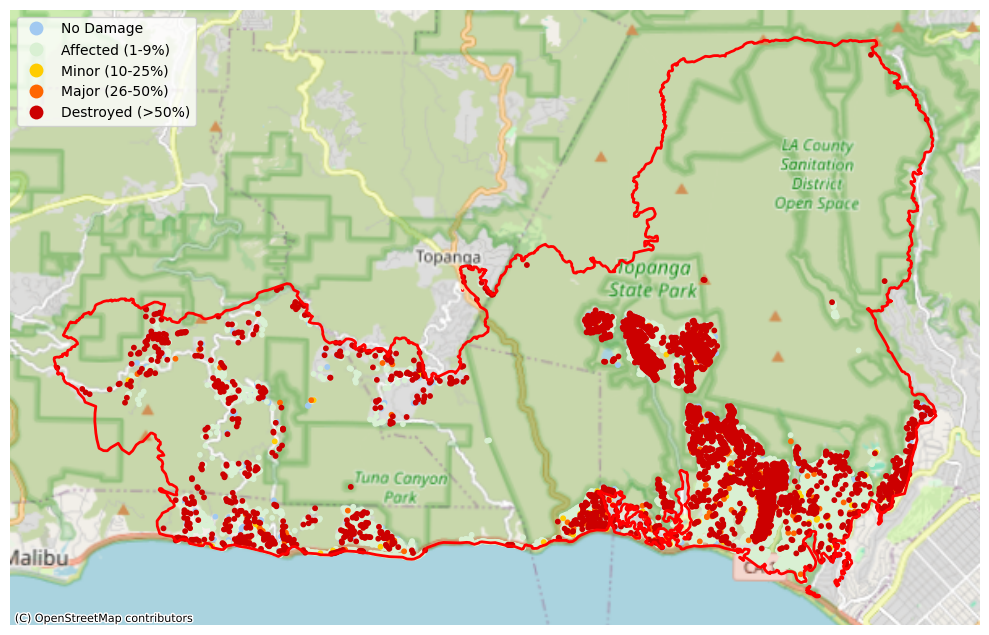

In [103]:
f, ax = plt.subplots(figsize=(10, 10))

# Plot the overlap_gdf with custom colormap for damage levels
overlap_gdf_sorted.plot(ax=ax, column="DAMAGE", s=10, cmap=cmap, legend=True,
                 legend_kwds={'labels': damage_labels})

gpd.GeoSeries(fire_perimeter_gdf.geometry.iloc[1]).plot(
    ax=ax, edgecolor="red", facecolor="none", linewidth=2
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=overlap_gdf.crs)

ax.set_axis_off()
plt.tight_layout()

plt.savefig('plots/pali_damage_all.png', dpi=300, bbox_inches='tight')

plt.show()

In [75]:
pali_dins_gdf = overlap_gdf.copy()

### Hummmmm, only Palisade

find another dataset here for Eaton
https://gis.data.cnra.ca.gov/datasets/CALFIRE-Forestry::dins-2025-eaton-public-view/about

In [93]:
eaton_dins_gdf = gpd.read_file("https://services1.arcgis.com/jUJYIo9tSA7EHvfZ/arcgis/rest/services/DINS_2025_Eaton_Public_View/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")
eaton_dins_gdf = eaton_dins_gdf.to_crs(fire_perimeter_gdf.crs)

In [94]:
# sort the gdf with damage level
eaton_dins_gdf.loc[:, 'DAMAGE'] = pd.Categorical(eaton_dins_gdf['DAMAGE'], categories=damage_order, ordered=True)
eaton_dins_gdf_sorted = eaton_dins_gdf.sort_values('DAMAGE', ascending=True)

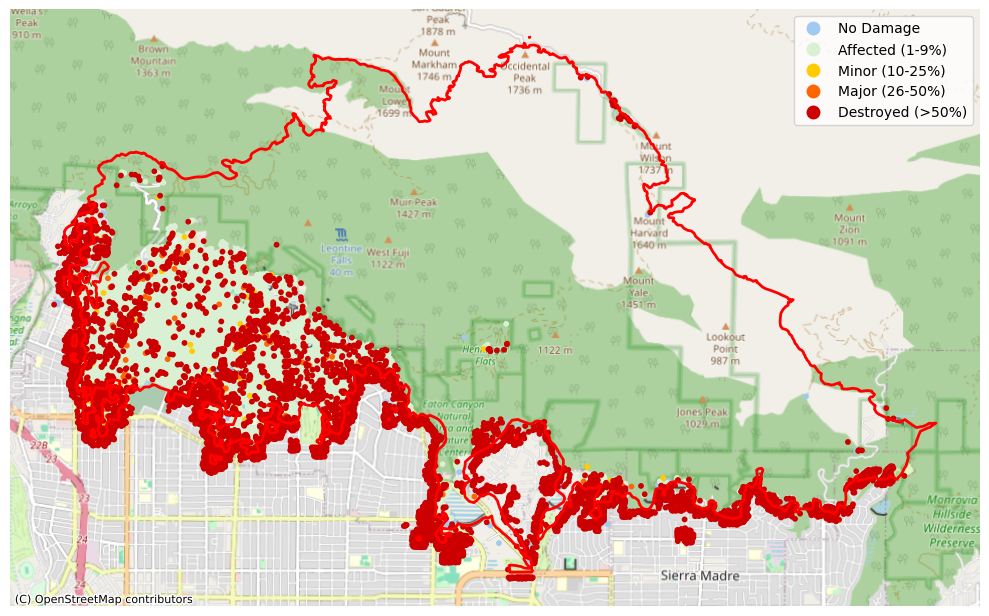

In [104]:
f,ax=plt.subplots(figsize=(10,10))

eaton_dins_gdf_sorted.plot(ax=ax, column="DAMAGE", s=10, cmap=cmap, legend=True,
                 legend_kwds={'labels': damage_labels})

gpd.GeoSeries(fire_perimeter_gdf.geometry.iloc[0]).plot(
    ax=ax, edgecolor="red", facecolor="none", linewidth=2
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=eaton_dins_gdf_sorted.crs)

ax.set_axis_off()
plt.tight_layout()

plt.savefig('plots/eaton_damage_all.png', dpi=300, bbox_inches='tight')

plt.show()

In [21]:
overlap_gdf = gpd.clip(eaton_dins_gdf,fire_perimeter_gdf)
eaton_dins_gdf = overlap_gdf.copy()

In [22]:
eaton_dins_gdf.to_file("DINS/Eaton_dins.geojson", driver="GeoJSON")
pali_dins_gdf.to_file("DINS/Palisades_dins.geojson", driver="GeoJSON")

### Now we have the dataset for Palisade and Eaton
"pali_dins_gdf" and "eaton_dins_gdf"

## Let's check out some Statistic now
in terms of census tracks in Palisades and Eaton

In [53]:
census_all = gpd.read_file('filt_study_area.geojson')
census_gdf = census_all[["TRACTCE", "geometry"]].copy()

In [60]:
census_pali = gpd.clip(census_gdf, fire_perimeter_gdf.iloc[1].geometry)
census_eaton = gpd.clip(census_gdf, fire_perimeter_gdf.iloc[0].geometry)

In [115]:
print(census_pali.shape)
print(census_eaton.shape)
# see how many census tracts in each region

(12, 7)
(23, 7)


Palisades has 12 census tracts and Eaton has 23.

### For Palisades

In [112]:
# total damage > 50%
total_pali_50 = pali_dins_gdf[pali_dins_gdf["DAMAGE"] == "Destroyed (>50%)"].shape[0]
total_eaton_50 = eaton_dins_gdf[eaton_dins_gdf["DAMAGE"] == "Destroyed (>50%)"].shape[0]

pali_perc = 100*(total_pali_50/pali_dins_gdf.shape[0])
eaton_perc = 100*(total_eaton_50/eaton_dins_gdf.shape[0])

print(f"Total structures destroyed (>50%) in Palisades: {total_pali_50} ({pali_perc:.2f}%)")
print(f"Total structures destroyed (>50%) in Eaton: {total_eaton_50} ({eaton_perc:.2f}%)")

Total structures destroyed (>50%) in Palisades: 6743 (63.54%)
Total structures destroyed (>50%) in Eaton: 9418 (51.11%)


In [56]:
# assign each structure to a census tract based on its location
pali_dins_with_tracts = gpd.sjoin(pali_dins_gdf, census_pali, how="left", predicate="within")

# aggregate Damage Counts by Census Tract
pali_damage_stats = pali_dins_with_tracts.groupby("TRACTCE")["DAMAGE"].value_counts().unstack(fill_value=0)
pali_damage_stats

DAMAGE,Affected (1-9%),Destroyed (>50%),Major (26-50%),Minor (10-25%),No Damage
TRACTCE,,,,,
262400,6,20,0,0,70
262501,35,832,2,4,87
262601,45,168,4,10,456
262604,138,649,5,41,571
262704,105,1415,12,30,563
262706,80,2019,10,15,136
262802,23,174,3,6,99
800104,2,8,0,0,37
800504,93,446,5,13,301


In [61]:
census_pali = census_pali.merge(pali_damage_stats, left_on="TRACTCE", right_index=True, how="left").sort_values(by="Destroyed (>50%)", ascending=False)
census_pali

,TRACTCE,geometry,Affected (1-9%),Destroyed (>50%),Major (26-50%),Minor (10-25%),No Damage
2,262706,"MULTIPOLYGON (((358258.021 3767695.981, 358270...",80.0,2019.0,10.0,15.0,136.0
1,262704,"MULTIPOLYGON (((356383.978 3767978.622, 356387...",105.0,1415.0,12.0,30.0,563.0
3,262501,"POLYGON ((358879.347 3769250.518, 358879.306 3...",35.0,832.0,2.0,4.0,87.0
6,800506,"MULTIPOLYGON (((347475.537 3771636.255, 347486...",117.0,763.0,15.0,26.0,369.0
9,262604,"MULTIPOLYGON (((355626.008 3769226.493, 355632...",138.0,649.0,5.0,41.0,571.0
5,800504,"POLYGON ((344623.622 3771364.207, 344627.977 3...",93.0,446.0,5.0,13.0,301.0
10,262802,"MULTIPOLYGON (((359833.488 3767094.15, 359825....",23.0,174.0,3.0,6.0,99.0
0,262601,"POLYGON ((354891.051 3772971.142, 355016.365 3...",45.0,168.0,4.0,10.0,456.0
8,980019,"POLYGON ((352823.464 3772744.179, 352838.178 3...",12.0,77.0,1.0,2.0,289.0
4,262400,"MULTIPOLYGON (((359711.581 3776751.307, 359719...",6.0,20.0,0.0,0.0,70.0


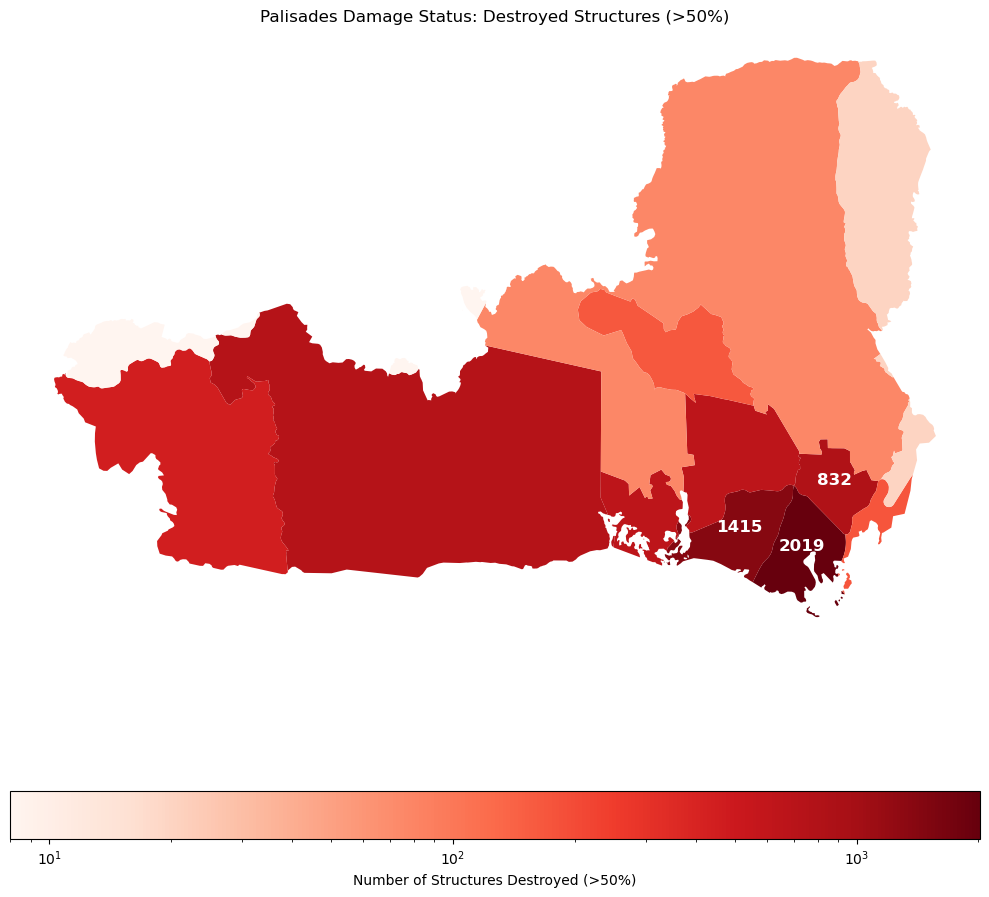

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

census_pali.plot(column="Destroyed (>50%)", ax=ax, cmap="Reds", legend=True,
               legend_kwds={'label': "Number of Structures Destroyed (>50%)", 'orientation': "horizontal"},
                norm=LogNorm())

# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=census_pali.crs.to_string())

# add text for the top-3 damage census tracts
top_3 = census_pali.nlargest(3, 'Destroyed (>50%)')
for idx, row in top_3.iterrows():
    centroid = row.geometry.centroid
    d_count = int(row['Destroyed (>50%)'])
    ax.text(centroid.x, centroid.y, str(d_count),
            fontsize=12, ha='center', color='white', fontweight='bold')


ax.set_title("Palisades Damage Status: Destroyed Structures (>50%)")
ax.set_axis_off() 

plt.tight_layout()

plt.savefig('plots/pali_damage_ct.png', dpi=300, bbox_inches='tight')

plt.show()

### For Eaton

In [99]:
# assign each structure to a census tract based on its location
eaton_dins_with_tracts = gpd.sjoin(eaton_dins_gdf, census_eaton, how="left", predicate="within")

# Aggregate Damage Counts by Census Tract
eaton_damage_stats = eaton_dins_with_tracts.groupby("TRACTCE")["DAMAGE"].value_counts().unstack(fill_value=0)
eaton_damage_stats

DAMAGE,Affected (1-9%),Destroyed (>50%),Major (26-50%),Minor (10-25%),No Damage
TRACTCE,,,,,
430301,0,0,0,0,11
430400,1,1,0,0,49
430501,12,25,1,4,114
430502,0,0,0,0,26
460001,2,8,1,0,84
460002,18,60,3,2,73
460101,119,1223,7,23,515
460200,92,2347,4,12,207
460301,75,599,2,14,188


In [100]:
census_eaton = census_eaton.merge(eaton_damage_stats, left_on="TRACTCE", right_index=True, how="left").sort_values(by="Destroyed (>50%)", ascending=False)
census_eaton

,TRACTCE,geometry,Affected (1-9%),Destroyed (>50%),Major (26-50%),Minor (10-25%),No Damage
31,460200,"POLYGON ((394234.007 3784659.594, 394249.664 3...",92.0,2347.0,4.0,12.0,207.0
18,461100,"MULTIPOLYGON (((394029.973 3784161.385, 394054...",82.0,1667.0,9.0,14.0,283.0
34,460101,"MULTIPOLYGON (((395742.166 3783997.276, 395746...",119.0,1223.0,7.0,23.0,515.0
23,461200,"MULTIPOLYGON (((395705.662 3783216.037, 395711...",95.0,997.0,7.0,9.0,414.0
33,460302,"MULTIPOLYGON (((393111.468 3785268.967, 393108...",58.0,930.0,6.0,7.0,276.0
20,461000,"MULTIPOLYGON (((393402.815 3784348.366, 393605...",47.0,842.0,5.0,13.0,232.0
32,460301,"POLYGON ((394170.96 3787078.235, 394446.959 37...",75.0,599.0,2.0,14.0,188.0
19,460900,"MULTIPOLYGON (((393364.148 3783353.109, 393380...",25.0,165.0,7.0,3.0,120.0
22,461501,"MULTIPOLYGON (((395135.318 3783129.075, 395131...",17.0,151.0,2.0,4.0,136.0
16,461300,"MULTIPOLYGON (((395688.66 3782846.808, 395691....",16.0,137.0,1.0,7.0,101.0


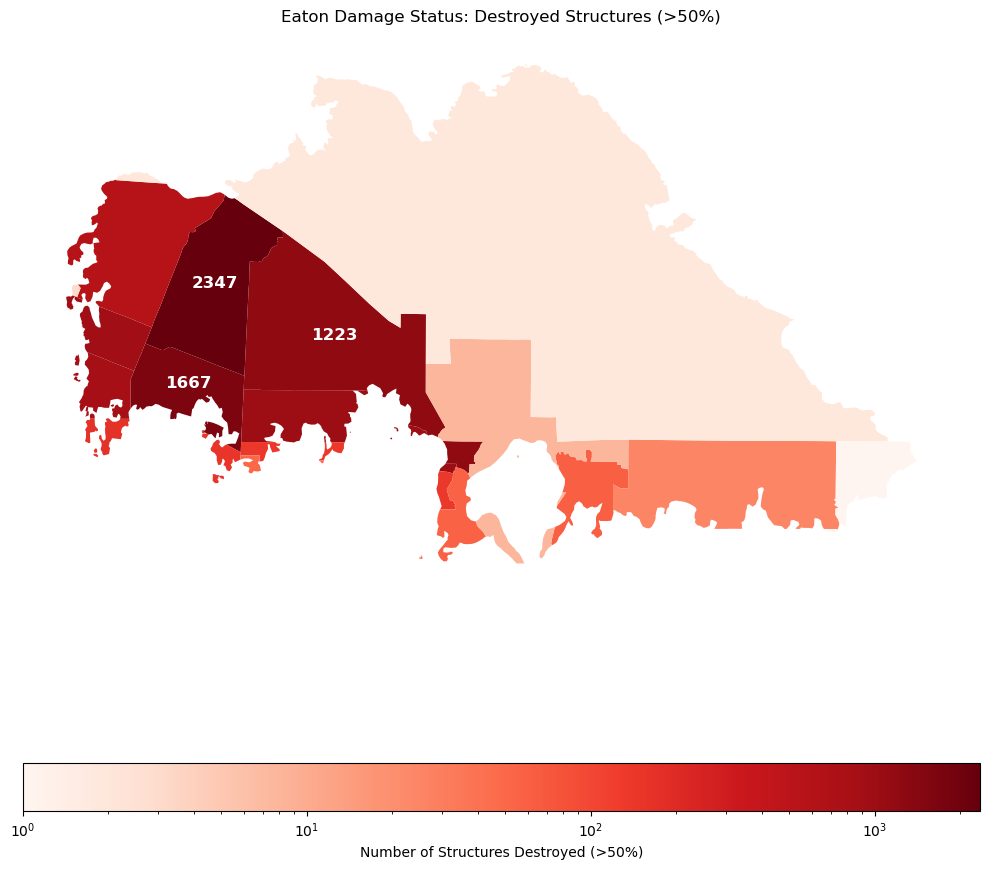

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

census_eaton.plot(column="Destroyed (>50%)", ax=ax, cmap="Reds", legend=True,
               legend_kwds={'label': "Number of Structures Destroyed (>50%)", 'orientation': "horizontal"},
                norm=LogNorm())

# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=census_pali.crs.to_string())


# add text for the top-3 damage census tracts
top_3 = census_eaton.nlargest(3, 'Destroyed (>50%)')
for idx, row in top_3.iterrows():
    centroid = row.geometry.centroid
    d_count = int(row['Destroyed (>50%)'])
    ax.text(centroid.x, centroid.y, str(d_count),
            fontsize=12, ha='center', color='white', fontweight='bold')

ax.set_title("Eaton Damage Status: Destroyed Structures (>50%)")
ax.set_axis_off() 

plt.tight_layout()

plt.savefig('plots/eaton_damage_ct.png', dpi=300, bbox_inches='tight')

plt.show()

In [114]:
# save census_pali and census_eaton for correlation
census_eaton.to_file("DINS/Eaton_dins_census.geojson", driver="GeoJSON")
census_pali.to_file("DINS/Palisades_dins_census.geojson", driver="GeoJSON")